In [47]:
# 1) Configuration (Quick run defaults)
import os, math, time, random, json, warnings
from dataclasses import dataclass
warnings.filterwarnings("ignore")
import torch
@dataclass
class CFG:
    dataset_path: str = "data\MVTec-AD"
    class_name: str = "screw"  # e.g., bottle, cable, hazelnut, screw, ...
    encoder_arch: str ="wide_resnet50_2" #"resnet18"  # light and fast; paper also uses wide_resnet50_2
    input_size: int = 256
    batch_size: int = 8
    epochs: int = 20 # quick run; increase for better results
    workers: int = 0  # Windows-safe DataLoader
    lr: float = 2e-4
    coupling_blocks: int = 4  # fewer for faster run
    condition_dim: int = 128
    clamp_alpha: float = 1.9
    seed: int = 42
    device: str = "cuda" if __import__("torch").cuda.is_available() else "cpu"
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
print("Config:")
print(CFG.device)

2.7.1+cu118
CUDA available: True
CUDA available: True
GPU count: 1
GPU name: NVIDIA GeForce GTX 1650
Config:
cuda


In [ ]:
def freia_cflow_head(c, n_feat):
    n_cond = c.condition_vec
    coder = Ff.SequenceINN(n_feat)
    print('CNF coder:', n_feat)
    for k in range(c.coupling_blocks):
        coder.append(Fm.AllInOneBlock, cond=0, cond_shape=(n_cond,), subnet_constructor=subnet_fc, affine_clamping=c.clamp_alpha,
            global_affine_type='SOFTPLUS', permute_soft=False)
    return coder

In [48]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import FrEIA.framework as Ff
import FrEIA.modules as Fm
print(f"PyTorch {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

PyTorch 2.7.1+cu118
CUDA: True


In [49]:
def positionalencoding2d(D, H, W):
    if D % 4 != 0:
        raise ValueError("positionalencoding2d: D must be divisible by 4")
    pe = torch.zeros(D, H, W)
    half = D // 2
    div_term = torch.exp(torch.arange(0., half, 2) * -(math.log(10000.0) / half))
    pos_w = torch.arange(0., W).unsqueeze(1)
    pos_h = torch.arange(0., H).unsqueeze(1)
    pe[0:half:2, :, :] = torch.sin(pos_w * div_term).T.unsqueeze(1).repeat(1, H, 1)
    pe[1:half:2, :, :] = torch.cos(pos_w * div_term).T.unsqueeze(1).repeat(1, H, 1)
    pe[half::2, :, :]  = torch.sin(pos_h * div_term).T.unsqueeze(2).repeat(1, 1, W)
    pe[half+1::2, :, :] = torch.cos(pos_h * div_term).T.unsqueeze(2).repeat(1, 1, W)
    return pe

def gaussian_nll_logprob(z, log_jac_det):
    # log N(z;0,I) = -0.5 * (k*log(2π) + ||z||^2) ; here we need negative of that for loss
    k = z.size(1)
    const = -0.5 * k * torch.log(torch.tensor(2 * math.pi, device=z.device, dtype=z.dtype))
    quad = -0.5 * torch.sum(z**2, dim=1)
    return const + quad + log_jac_det

In [50]:
class MVTecDataset(Dataset):
    def __init__(self, dataset_path, class_name, is_train=True, resize=256, cropsize=256):
        self.dataset_path = dataset_path; self.class_name = class_name
        self.is_train = is_train; self.resize = resize; self.cropsize = cropsize
        self.x, self.y, self.mask = self._gather()
        self.t_img = T.Compose([
            T.Resize(resize, interpolation=Image.Resampling.LANCZOS),
            T.CenterCrop(cropsize),
            T.ToTensor(),
            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
        self.t_mask = T.Compose([
            T.Resize(resize, interpolation=Image.Resampling.NEAREST),
            T.CenterCrop(cropsize),
            T.ToTensor()
        ])
    def _gather(self):
        phase = 'train' if self.is_train else 'test'
        img_dir = os.path.join(self.dataset_path, self.class_name, phase)
        gt_dir = os.path.join(self.dataset_path, self.class_name, 'ground_truth')
        x,y,m = [],[],[]
        if not os.path.isdir(img_dir):
            raise FileNotFoundError(f"Missing {img_dir}")
        for typ in sorted(os.listdir(img_dir)):
            tdir = os.path.join(img_dir, typ)
            if not os.path.isdir(tdir): continue
            files = sorted([os.path.join(tdir,f) for f in os.listdir(tdir) if f.endswith('.png')])
            x.extend(files)
            if typ=='good':
                y.extend([0]*len(files)); m.extend([None]*len(files))
            else:
                y.extend([1]*len(files))
                gt_tdir = os.path.join(gt_dir, typ)
                base = [os.path.splitext(os.path.basename(f))[0] for f in files]
                m.extend([os.path.join(gt_tdir, b+'_mask.png') for b in base])
        assert len(x)==len(y)
        return x,y,m
    def __len__(self): return len(self.x)
    def __getitem__(self, idx):
        img = Image.open(self.x[idx]).convert('RGB')
        img = self.t_img(img)
        if self.y[idx]==0:
            mask = torch.zeros(1, self.cropsize, self.cropsize)
        else:
            mask = Image.open(self.mask[idx])
            mask = self.t_mask(mask)
        return img, self.y[idx], mask

In [51]:
def load_encoder(arch, pool_layers):
    acts = {}
    def hook(name):
        def _fn(m,i,o): acts[name]=o.detach()
        return _fn
    if arch=='resnet18':
        enc = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        layers = [enc.layer2, enc.layer3, enc.layer4]
        dims = [enc.layer2[-1].conv2.out_channels, enc.layer3[-1].conv2.out_channels, enc.layer4[-1].conv2.out_channels]
    elif arch=='wide_resnet50_2':
        enc = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT)
        layers = [enc.layer2, enc.layer3, enc.layer4]
        dims = [enc.layer2[-1].conv3.out_channels, enc.layer3[-1].conv3.out_channels, enc.layer4[-1].conv3.out_channels]
    else:
        raise NotImplementedError(arch)
    L = min(len(pool_layers), len(layers))
    for i in range(L): layers[i].register_forward_hook(hook(pool_layers[i]))
    return enc.eval(), pool_layers[:L], dims[:L], acts

In [52]:
def subnet_fc(d_in, d_out):
    return nn.Sequential(nn.Linear(d_in, 2*d_in), nn.ReLU(), nn.Linear(2*d_in, d_out))

def build_cflow_head(n_feat, condition_vec, coupling_blocks, clamp_alpha):
    coder = Ff.SequenceINN(n_feat)
    for _ in range(coupling_blocks):
        coder.append(Fm.AllInOneBlock, cond=0, cond_shape=(condition_vec,),
                    subnet_constructor=subnet_fc, affine_clamping=clamp_alpha,
                    global_affine_type='SOFTPLUS', permute_soft=False)
    return coder

In [53]:
def train_epoch2(encoder, decoders, loader, optimizer, device, pool_layers, acts, P):
    for d in decoders: d.train()
    log_sigmoid = nn.LogSigmoid()
    total_loss = 0.0; total_B = 0
    N = 256
    for images, _, _ in tqdm(loader, desc='Train'):
        images = images.to(device)
        optimizer.zero_grad()
        with torch.no_grad(): _ = encoder(images)
        loss_sum = 0.0
        for l, name in enumerate(pool_layers):
            e = acts[name]
            B,C,H,W = e.size(); S = H*W; E = B*S
            p = positionalencoding2d(P, H, W).to(device).unsqueeze(0).repeat(B,1,1,1)
            c_r = p.reshape(B,P,S).transpose(1,2).reshape(E,P)
            e_r = e.reshape(B,C,S).transpose(1,2).reshape(E,C)
            perm = torch.randperm(E, device=device)
            FIB = max(1, E // N)
            dec = decoders[l]
            for f in range(FIB):
                idx = torch.arange(f*N, min((f+1)*N, E), device=device)
                if idx.numel()==0: continue
                c_p = c_r[perm[idx]]; e_p = e_r[perm[idx]]
                z, log_jac = dec(e_p, [c_p,])
                log_prob = gaussian_nll_logprob(z, log_jac) / C
                loss = -log_sigmoid(log_prob).sum()
                loss_sum += loss
        loss_sum.backward()
        optimizer.step()
        total_loss += loss_sum.item(); total_B += images.size(0)
    return total_loss / max(1,total_B)


### new train loop


In [54]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

def train_epoch1(encoder, decoders, loader, optimizer, device, pool_layers, acts, P):
    encoder.eval()  # freeze encoder (feature extractor)
    for d in decoders: 
        d.train()

    log_sigmoid = nn.LogSigmoid()
    scaler = GradScaler()
    total_loss = 0.0
    total_B = 0
    N = 2048  # larger batch size per layer for higher GPU utilization

    for images, _, _ in tqdm(loader, desc='Train', leave=False):
        images = images.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        # ---- Get encoder features ----
        with torch.no_grad():
            _ = encoder(images)

        loss_sum = 0.0

        # ---- Process each selected feature layer ----
        for l, name in enumerate(pool_layers):
            e = acts[name].to(device, non_blocking=True)  # B, C, H, W
            B, C, H, W = e.size()
            S = H * W
            E = B * S

            # Generate positional encodings (reuse across batches if possible)
            p = positionalencoding2d(P, H, W).to(device, non_blocking=True)
            p = p.unsqueeze(0).expand(B, -1, H, W)  # B×P×H×W

            # Flatten spatial dimensions
            e_flat = e.permute(0, 2, 3, 1).reshape(E, C)   # (E, C)
            p_flat = p.permute(0, 2, 3, 1).reshape(E, P)   # (E, P)

            # Shuffle once
            perm = torch.randperm(E, device=device)
            e_flat = e_flat[perm]
            p_flat = p_flat[perm]

            # Process in chunks for memory safety
            dec = decoders[l]
            for i in range(0, E, N):
                e_chunk = e_flat[i:i+N]
                p_chunk = p_flat[i:i+N]

                with autocast():
                    z, log_jac = dec(e_chunk, [p_chunk])
                    log_prob = gaussian_nll_logprob(z, log_jac) / C
                    loss = -log_sigmoid(log_prob).mean()

                scaler.scale(loss).backward()
                loss_sum += loss.detach()

        # ---- Optimizer step (after all layers processed) ----
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss_sum.item()
        total_B += images.size(0)

    torch.cuda.synchronize()  # optional: for accurate timing/profiling
    return total_loss / max(1, total_B)


In [ ]:
import os
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

def save_checkpoint(encoder, decoders, optimizer, epoch, class_name,save_dir="./weights"):
    """
    Save encoder, decoders, and optimizer state for checkpointing.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save encoder
    torch.save(encoder.state_dict(), os.path.join(save_dir, f"encoder_{class_name}.pth"))

    # Save decoders
    for i, dec in enumerate(decoders):
        torch.save(dec.state_dict(), os.path.join(save_dir, f"decoder_{i}_{class_name}.pth"))

    # Save optimizer state (optional)
    torch.save(optimizer.state_dict(), os.path.join(save_dir, f"optimizer_{class_name}.pth"))

    print(f"✅ Checkpoint saved to {save_dir} (epoch {epoch})")


def train_epoch(encoder, decoders, loader, optimizer, device, pool_layers, acts, P, class_name, epoch=0, save_dir="./weights", best_loss=float("inf")):
    encoder.eval()
    for d in decoders:
        d.train()

    log_sigmoid = nn.LogSigmoid()
    scaler = GradScaler()
    total_loss = 0.0
    total_B = 0
    N = 2048

    for images, _, _ in tqdm(loader, desc=f"Train Epoch {epoch}", leave=False):
        images = images.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            _ = encoder(images)

        loss_sum = 0.0
        for l, name in enumerate(pool_layers):
            e = acts[name].to(device, non_blocking=True)
            B, C, H, W = e.size()
            S = H * W
            E = B * S

            p = positionalencoding2d(P, H, W).to(device, non_blocking=True)
            p = p.unsqueeze(0).expand(B, -1, H, W)

            e_flat = e.permute(0, 2, 3, 1).reshape(E, C)
            p_flat = p.permute(0, 2, 3, 1).reshape(E, P)

            perm = torch.randperm(E, device=device)
            e_flat = e_flat[perm]
            p_flat = p_flat[perm]

            dec = decoders[l]
            for i in range(0, E, N):
                e_chunk = e_flat[i:i+N]
                p_chunk = p_flat[i:i+N]

                with autocast():
                    z, log_jac = dec(e_chunk, [p_chunk])
                    log_prob = gaussian_nll_logprob(z, log_jac) / C
                    loss = -log_sigmoid(log_prob).mean()

                scaler.scale(loss).backward()
                loss_sum += loss.detach()

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss_sum.item()
        total_B += images.size(0)

    torch.cuda.synchronize()
    avg_loss = total_loss / max(1, total_B)
    print(f"✅ Epoch {epoch} completed | Avg loss: {avg_loss:.6f}")

    # ---- Save only if this is the best loss so far ----
    if avg_loss < best_loss:
        save_checkpoint(
            encoder=encoder,
            decoders=decoders,
            optimizer=optimizer,
            epoch=epoch,
            class_name=class_name,
            save_dir=save_dir
        )
        print(f"🏆 New best model saved! (loss: {avg_loss:.6f})")
        best_loss = avg_loss

    return avg_loss, best_loss



In [56]:
def test_epoch(encoder, decoders, loader, device, pool_layers, acts, P, cropsize):
    for d in decoders: d.eval()
    heights, widths = [], []
    dists = [[] for _ in pool_layers]
    gt_label_list, gt_mask_list = [], []
    with torch.no_grad():
        for i,(images, labels, masks) in enumerate(tqdm(loader, desc='Test')):
            gt_label_list.extend(labels.numpy()); gt_mask_list.extend(masks.numpy())
            images = images.to(device)
            _ = encoder(images)
            for l,name in enumerate(pool_layers):
                e = acts[name]
                B,C,H,W = e.size(); S=H*W; E=B*S
                if i==0: heights.append(H); widths.append(W)
                p = positionalencoding2d(P, H, W).to(device).unsqueeze(0).repeat(B,1,1,1)
                c_r = p.reshape(B,P,S).transpose(1,2).reshape(E,P)
                e_r = e.reshape(B,C,S).transpose(1,2).reshape(E,C)
                dec = decoders[l]
                z, log_jac = dec(e_r, [c_r,])
                log_prob = gaussian_nll_logprob(z, log_jac) / C
                dists[l].extend(log_prob.detach().cpu().tolist())
    return heights, widths, dists, gt_label_list, gt_mask_list


In [57]:
def compute_anomaly_map(dists, heights, widths, cropsize, pool_layers):
    maps = []
    for l in range(len(pool_layers)):
        t = torch.tensor(dists[l], dtype=torch.double)
        t -= torch.max(t); prob = torch.exp(t)
        m = prob.reshape(-1, heights[l], widths[l])
        up = F.interpolate(m.unsqueeze(1), size=(cropsize,cropsize), mode='bilinear', align_corners=True).squeeze().numpy()
        maps.append(up)
    score = np.zeros_like(maps[0])
    for m in maps: score += m
    super_mask = score.max() - score
    return super_mask

In [58]:
def set_seeds(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
set_seeds(CFG.seed)

def change_class(class_name):
    CFG.class_name = class_name
    device = torch.device(CFG.device)
    train_ds = MVTecDataset(CFG.dataset_path, CFG.class_name, True, CFG.input_size, CFG.input_size)
    test_ds = MVTecDataset(CFG.dataset_path, CFG.class_name, False, CFG.input_size, CFG.input_size)
    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.workers, pin_memory=True, drop_last=True)
    test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.workers, pin_memory=True)
    print(f"Train: {len(train_ds)} | Test: {len(test_ds)} | Batches: {len(train_loader)}/{len(test_loader)}")
    pool_layers = ['layer0','layer1','layer2']
    encoder, pool_layers, pool_dims, acts = load_encoder(CFG.encoder_arch, pool_layers)
    encoder = encoder.to(device).eval()
    decoders = []
    for d in pool_dims:
        dec = build_cflow_head(d, CFG.condition_dim, CFG.coupling_blocks, CFG.clamp_alpha).to(device)
        decoders.append(dec)
    for p in encoder.parameters(): p.requires_grad=False
    optim = torch.optim.Adam([p for d in decoders for p in d.parameters()], lr=CFG.lr)
print("Init done.")

Init done.


In [65]:
mvtec_classes = ["grid","pill", "screw", "toothbrush"] 
# , "hazelnut", "leather", "metal_nut","wood","tile", "transistor",  "zipper"
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def step(self, current_loss):
        if self.best_loss - current_loss > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return True  # improved
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False  # no improvement

for cl in mvtec_classes:
    CFG.class_name = cl
    device = torch.device(CFG.device)
    train_ds = MVTecDataset(CFG.dataset_path, CFG.class_name, True, CFG.input_size, CFG.input_size)
    test_ds = MVTecDataset(CFG.dataset_path, CFG.class_name, False, CFG.input_size, CFG.input_size)
    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.workers, pin_memory=True, drop_last=True)
    test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.workers, pin_memory=True)
    print(f"Train: {len(train_ds)} | Test: {len(test_ds)} | Batches: {len(train_loader)}/{len(test_loader)}")
    pool_layers = ['layer0','layer1','layer2']
    encoder, pool_layers, pool_dims, acts = load_encoder(CFG.encoder_arch, pool_layers)


    decoders = []
    for d in pool_dims:
        dec = build_cflow_head(d, CFG.condition_dim, CFG.coupling_blocks, CFG.clamp_alpha).to(device)
        decoders.append(dec)
    encoder = encoder.to(device).eval()
    class_name = CFG.class_name
    weight_dir = "./weights"  # or your custom path
    # Load encoder weights
    encoder_path = os.path.join(weight_dir, f"encoder_{class_name}.pth")
    encoder.load_state_dict(torch.load(encoder_path, map_location=device))
    print(f"✅ Loaded encoder weights from {encoder_path}")

# Load decoder weights
    for i, dec in enumerate(decoders):
        dec_path = os.path.join(weight_dir, f"decoder_{i}_{class_name}.pth")
        dec.load_state_dict(torch.load(dec_path, map_location=device))
        dec.eval()
        print(f"✅ Loaded decoder {i} weights from {dec_path}")

    # decoders = []
    # for d in pool_dims:
    #     dec = build_cflow_head(d, CFG.condition_dim, CFG.coupling_blocks, CFG.clamp_alpha).to(device)
    #     decoders.append(dec)

    for p in encoder.parameters(): p.requires_grad=False
    early_stopping = EarlyStopping(patience=5, min_delta=1e-3)
    best_loss = float("inf")

    optim = torch.optim.Adam([p for d in decoders for p in d.parameters()], lr=CFG.lr)
    history = {"loss": []}
    start = time.time()
    for epoch in range(CFG.epochs):
        loss,best_loss = train_epoch(encoder, decoders, train_loader, optim, device, pool_layers, acts, CFG.condition_dim,class_name=cl)
        history["loss"].append(loss)
        print(f"Epoch {epoch+1}/{CFG.epochs} - loss {loss:.4f} - best_loss {best_loss:.4f}")
        early_stopping.step(loss)
        if early_stopping.early_stop or loss < .02:
            print(f"⏹ Early stopping triggered at epoch {epoch+1}. Best loss: {best_loss:.4f}")
            break
    print(f"Training took {(time.time()-start):.1f}s")

Train: 264 | Test: 78 | Batches: 33/10
✅ Loaded encoder weights from ./weights\encoder_grid.pth
✅ Loaded decoder 0 weights from ./weights\decoder_0_grid.pth
✅ Loaded decoder 1 weights from ./weights\decoder_1_grid.pth
✅ Loaded decoder 2 weights from ./weights\decoder_2_grid.pth


✅ Epoch 0 completed | Avg loss: 0.540163
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.540163)
Epoch 1/20 - loss 0.5402 - best_loss 0.5402


✅ Epoch 0 completed | Avg loss: 0.439314
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.439314)
Epoch 2/20 - loss 0.4393 - best_loss 0.4393


✅ Epoch 0 completed | Avg loss: 0.420761
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.420761)
Epoch 3/20 - loss 0.4208 - best_loss 0.4208


✅ Epoch 0 completed | Avg loss: 0.409457
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.409457)
Epoch 4/20 - loss 0.4095 - best_loss 0.4095


✅ Epoch 0 completed | Avg loss: 0.400461
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.400461)
Epoch 5/20 - loss 0.4005 - best_loss 0.4005


✅ Epoch 0 completed | Avg loss: 0.392481
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.392481)
Epoch 6/20 - loss 0.3925 - best_loss 0.3925


✅ Epoch 0 completed | Avg loss: 0.385305
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.385305)
Epoch 7/20 - loss 0.3853 - best_loss 0.3853


✅ Epoch 0 completed | Avg loss: 0.378964
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.378964)
Epoch 8/20 - loss 0.3790 - best_loss 0.3790


✅ Epoch 0 completed | Avg loss: 0.373738
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.373738)
Epoch 9/20 - loss 0.3737 - best_loss 0.3737


✅ Epoch 0 completed | Avg loss: 0.368783
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.368783)
Epoch 10/20 - loss 0.3688 - best_loss 0.3688


✅ Epoch 0 completed | Avg loss: 0.364380
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.364380)
Epoch 11/20 - loss 0.3644 - best_loss 0.3644


✅ Epoch 0 completed | Avg loss: 0.360106
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.360106)
Epoch 12/20 - loss 0.3601 - best_loss 0.3601


✅ Epoch 0 completed | Avg loss: 0.356215
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.356215)
Epoch 13/20 - loss 0.3562 - best_loss 0.3562


✅ Epoch 0 completed | Avg loss: 0.352830
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.352830)
Epoch 14/20 - loss 0.3528 - best_loss 0.3528


✅ Epoch 0 completed | Avg loss: 0.349505
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.349505)
Epoch 15/20 - loss 0.3495 - best_loss 0.3495


✅ Epoch 0 completed | Avg loss: 0.346504
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.346504)
Epoch 16/20 - loss 0.3465 - best_loss 0.3465


✅ Epoch 0 completed | Avg loss: 0.343700
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.343700)
Epoch 17/20 - loss 0.3437 - best_loss 0.3437


✅ Epoch 0 completed | Avg loss: 0.340661
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.340661)
Epoch 18/20 - loss 0.3407 - best_loss 0.3407


✅ Epoch 0 completed | Avg loss: 0.338190
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.338190)
Epoch 19/20 - loss 0.3382 - best_loss 0.3382


✅ Epoch 0 completed | Avg loss: 0.335579
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.335579)
Epoch 20/20 - loss 0.3356 - best_loss 0.3356
Training took 1566.8s
Train: 267 | Test: 167 | Batches: 33/21
✅ Loaded encoder weights from ./weights\encoder_pill.pth
✅ Loaded decoder 0 weights from ./weights\decoder_0_pill.pth
✅ Loaded decoder 1 weights from ./weights\decoder_1_pill.pth
✅ Loaded decoder 2 weights from ./weights\decoder_2_pill.pth


✅ Epoch 0 completed | Avg loss: 0.618528
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.618528)
Epoch 1/20 - loss 0.6185 - best_loss 0.6185


✅ Epoch 0 completed | Avg loss: 0.412958
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.412958)
Epoch 2/20 - loss 0.4130 - best_loss 0.4130


✅ Epoch 0 completed | Avg loss: 0.391050
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.391050)
Epoch 3/20 - loss 0.3910 - best_loss 0.3910


✅ Epoch 0 completed | Avg loss: 0.382594
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.382594)
Epoch 4/20 - loss 0.3826 - best_loss 0.3826


✅ Epoch 0 completed | Avg loss: 0.377831
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.377831)
Epoch 5/20 - loss 0.3778 - best_loss 0.3778


✅ Epoch 0 completed | Avg loss: 0.374489
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.374489)
Epoch 6/20 - loss 0.3745 - best_loss 0.3745


✅ Epoch 0 completed | Avg loss: 0.371624
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.371624)
Epoch 7/20 - loss 0.3716 - best_loss 0.3716


✅ Epoch 0 completed | Avg loss: 0.369300
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.369300)
Epoch 8/20 - loss 0.3693 - best_loss 0.3693


✅ Epoch 0 completed | Avg loss: 0.367167
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.367167)
Epoch 9/20 - loss 0.3672 - best_loss 0.3672


✅ Epoch 0 completed | Avg loss: 0.365169
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.365169)
Epoch 10/20 - loss 0.3652 - best_loss 0.3652


✅ Epoch 0 completed | Avg loss: 0.363166
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.363166)
Epoch 11/20 - loss 0.3632 - best_loss 0.3632


✅ Epoch 0 completed | Avg loss: 0.361392
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.361392)
Epoch 12/20 - loss 0.3614 - best_loss 0.3614


✅ Epoch 0 completed | Avg loss: 0.359725
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.359725)
Epoch 13/20 - loss 0.3597 - best_loss 0.3597


✅ Epoch 0 completed | Avg loss: 0.358030
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.358030)
Epoch 14/20 - loss 0.3580 - best_loss 0.3580


✅ Epoch 0 completed | Avg loss: 0.356380
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.356380)
Epoch 15/20 - loss 0.3564 - best_loss 0.3564


✅ Epoch 0 completed | Avg loss: 0.354881
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.354881)
Epoch 16/20 - loss 0.3549 - best_loss 0.3549


✅ Epoch 0 completed | Avg loss: 0.353235
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.353235)
Epoch 17/20 - loss 0.3532 - best_loss 0.3532


✅ Epoch 0 completed | Avg loss: 0.351759
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.351759)
Epoch 18/20 - loss 0.3518 - best_loss 0.3518


✅ Epoch 0 completed | Avg loss: 0.350329
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.350329)
Epoch 19/20 - loss 0.3503 - best_loss 0.3503


✅ Epoch 0 completed | Avg loss: 0.348865
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.348865)
Epoch 20/20 - loss 0.3489 - best_loss 0.3489
Training took 1521.5s
Train: 320 | Test: 160 | Batches: 40/20
✅ Loaded encoder weights from ./weights\encoder_screw.pth
✅ Loaded decoder 0 weights from ./weights\decoder_0_screw.pth
✅ Loaded decoder 1 weights from ./weights\decoder_1_screw.pth
✅ Loaded decoder 2 weights from ./weights\decoder_2_screw.pth


✅ Epoch 0 completed | Avg loss: 0.469693
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.469693)
Epoch 1/20 - loss 0.4697 - best_loss 0.4697


✅ Epoch 0 completed | Avg loss: 0.362806
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.362806)
Epoch 2/20 - loss 0.3628 - best_loss 0.3628


✅ Epoch 0 completed | Avg loss: 0.346629
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.346629)
Epoch 3/20 - loss 0.3466 - best_loss 0.3466


✅ Epoch 0 completed | Avg loss: 0.340551
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.340551)
Epoch 4/20 - loss 0.3406 - best_loss 0.3406


✅ Epoch 0 completed | Avg loss: 0.336930
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.336930)
Epoch 5/20 - loss 0.3369 - best_loss 0.3369


✅ Epoch 0 completed | Avg loss: 0.334217
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.334217)
Epoch 6/20 - loss 0.3342 - best_loss 0.3342


✅ Epoch 0 completed | Avg loss: 0.332030
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.332030)
Epoch 7/20 - loss 0.3320 - best_loss 0.3320


✅ Epoch 0 completed | Avg loss: 0.330094
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.330094)
Epoch 8/20 - loss 0.3301 - best_loss 0.3301


✅ Epoch 0 completed | Avg loss: 0.328376
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.328376)
Epoch 9/20 - loss 0.3284 - best_loss 0.3284


✅ Epoch 0 completed | Avg loss: 0.326728
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.326728)
Epoch 10/20 - loss 0.3267 - best_loss 0.3267


✅ Epoch 0 completed | Avg loss: 0.325208
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.325208)
Epoch 11/20 - loss 0.3252 - best_loss 0.3252


✅ Epoch 0 completed | Avg loss: 0.323695
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.323695)
Epoch 12/20 - loss 0.3237 - best_loss 0.3237


✅ Epoch 0 completed | Avg loss: 0.322239
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.322239)
Epoch 13/20 - loss 0.3222 - best_loss 0.3222


✅ Epoch 0 completed | Avg loss: 0.320762
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.320762)
Epoch 14/20 - loss 0.3208 - best_loss 0.3208


✅ Epoch 0 completed | Avg loss: 0.319377
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.319377)
Epoch 15/20 - loss 0.3194 - best_loss 0.3194


✅ Epoch 0 completed | Avg loss: 0.317993
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.317993)
Epoch 16/20 - loss 0.3180 - best_loss 0.3180


✅ Epoch 0 completed | Avg loss: 0.316606
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.316606)
Epoch 17/20 - loss 0.3166 - best_loss 0.3166


✅ Epoch 0 completed | Avg loss: 0.315268
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.315268)
Epoch 18/20 - loss 0.3153 - best_loss 0.3153


✅ Epoch 0 completed | Avg loss: 0.314035
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.314035)
Epoch 19/20 - loss 0.3140 - best_loss 0.3140


✅ Epoch 0 completed | Avg loss: 0.312911
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.312911)
Epoch 20/20 - loss 0.3129 - best_loss 0.3129
Training took 1841.2s
Train: 60 | Test: 42 | Batches: 7/6
✅ Loaded encoder weights from ./weights\encoder_toothbrush.pth
✅ Loaded decoder 0 weights from ./weights\decoder_0_toothbrush.pth
✅ Loaded decoder 1 weights from ./weights\decoder_1_toothbrush.pth
✅ Loaded decoder 2 weights from ./weights\decoder_2_toothbrush.pth


✅ Epoch 0 completed | Avg loss: 0.601520
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.601520)
Epoch 1/20 - loss 0.6015 - best_loss 0.6015


✅ Epoch 0 completed | Avg loss: 0.568810
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.568810)
Epoch 2/20 - loss 0.5688 - best_loss 0.5688


✅ Epoch 0 completed | Avg loss: 0.554723
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.554723)
Epoch 3/20 - loss 0.5547 - best_loss 0.5547


✅ Epoch 0 completed | Avg loss: 0.543868
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.543868)
Epoch 4/20 - loss 0.5439 - best_loss 0.5439


✅ Epoch 0 completed | Avg loss: 0.536178
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.536178)
Epoch 5/20 - loss 0.5362 - best_loss 0.5362


✅ Epoch 0 completed | Avg loss: 0.528855
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.528855)
Epoch 6/20 - loss 0.5289 - best_loss 0.5289


✅ Epoch 0 completed | Avg loss: 0.523873
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.523873)
Epoch 7/20 - loss 0.5239 - best_loss 0.5239


✅ Epoch 0 completed | Avg loss: 0.518967
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.518967)
Epoch 8/20 - loss 0.5190 - best_loss 0.5190


✅ Epoch 0 completed | Avg loss: 0.514599
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.514599)
Epoch 9/20 - loss 0.5146 - best_loss 0.5146


✅ Epoch 0 completed | Avg loss: 0.509754
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.509754)
Epoch 10/20 - loss 0.5098 - best_loss 0.5098


✅ Epoch 0 completed | Avg loss: 0.506766
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.506766)
Epoch 11/20 - loss 0.5068 - best_loss 0.5068


✅ Epoch 0 completed | Avg loss: 0.502253
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.502253)
Epoch 12/20 - loss 0.5023 - best_loss 0.5023


✅ Epoch 0 completed | Avg loss: 0.498900
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.498900)
Epoch 13/20 - loss 0.4989 - best_loss 0.4989


✅ Epoch 0 completed | Avg loss: 0.495249
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.495249)
Epoch 14/20 - loss 0.4952 - best_loss 0.4952


✅ Epoch 0 completed | Avg loss: 0.491861
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.491861)
Epoch 15/20 - loss 0.4919 - best_loss 0.4919


✅ Epoch 0 completed | Avg loss: 0.488246
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.488246)
Epoch 16/20 - loss 0.4882 - best_loss 0.4882


✅ Epoch 0 completed | Avg loss: 0.485592
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.485592)
Epoch 17/20 - loss 0.4856 - best_loss 0.4856


✅ Epoch 0 completed | Avg loss: 0.482115
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.482115)
Epoch 18/20 - loss 0.4821 - best_loss 0.4821


✅ Epoch 0 completed | Avg loss: 0.479037
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.479037)
Epoch 19/20 - loss 0.4790 - best_loss 0.4790


✅ Epoch 0 completed | Avg loss: 0.476289
✅ Checkpoint saved to ./weights (epoch 0)
🏆 New best model saved! (loss: 0.476289)
Epoch 20/20 - loss 0.4763 - best_loss 0.4763
Training took 347.1s


Test: 100%|██████████| 19/19 [00:30<00:00,  1.60s/it]


Detection AUROC: 94.04%


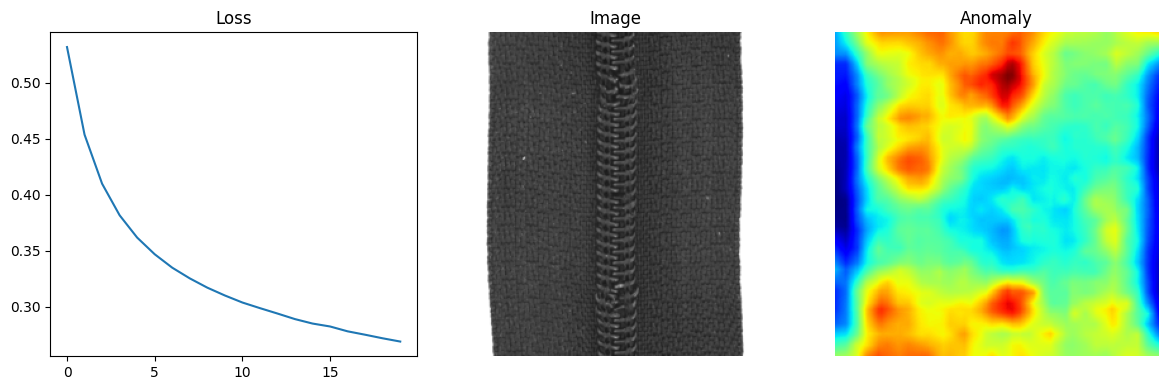

In [60]:
from sklearn.metrics import roc_auc_score
heights, widths, dists, gt_label_list, gt_mask_list = test_epoch(encoder, decoders, test_loader, device, pool_layers, acts, CFG.condition_dim, CFG.input_size)
super_mask = compute_anomaly_map(dists, heights, widths, CFG.input_size, pool_layers)
score_label = np.max(super_mask, axis=(1,2))
gt_label = np.asarray(gt_label_list, dtype=bool)
det_auroc = float(roc_auc_score(gt_label, score_label)*100)
print(f"Detection AUROC: {det_auroc:.2f}%")
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(history['loss']); ax[0].set_title('Loss')
idx = min(0, len(test_ds)-1)
img = Image.open(test_ds.x[idx]).convert('RGB').resize((CFG.input_size, CFG.input_size))
ax[1].imshow(img); ax[1].set_title('Image'); ax[1].axis('off')
ax[2].imshow(super_mask[idx], cmap='jet'); ax[2].set_title('Anomaly'); ax[2].axis('off')
plt.tight_layout(); plt.show()

In [61]:
import torch
from tqdm import tqdm

def load_model_weights(encoder, decoders, weight_dir, device,class_name="screw"):
    """
    Load pretrained weights for encoder and each decoder.
    """
    # Load encoder weights
    enc_path = f"{weight_dir}/encoder_{class_name}.pth"
    enc_state = torch.load(enc_path, map_location=device)
    encoder.load_state_dict(enc_state)
    encoder.to(device).eval()

    # Load decoder weights
    for i, dec in enumerate(decoders):
        dec_path = f"{weight_dir}/decoder_{i}_{class_name}.pth"
        dec_state = torch.load(dec_path, map_location=device)
        dec.load_state_dict(dec_state)
        dec.to(device).eval()

    print(f"✅ Loaded encoder from {enc_path}")
    print(f"✅ Loaded {len(decoders)} decoders from {weight_dir}")

    return encoder, decoders


@torch.no_grad()
def test_epoch_with_weights(encoder, decoders, loader, device, pool_layers, acts, P, cropsize, weight_dir,class_name="screw"):
    """
    Full evaluation pass using pretrained model weights.
    """
    # 1️⃣ Load weights
    encoder, decoders = load_model_weights(encoder, decoders, weight_dir, device,class_name)

    # 2️⃣ Prepare for testing
    heights, widths = [], []
    dists = [[] for _ in pool_layers]
    gt_label_list, gt_mask_list = [], []

    # 3️⃣ Run test loop
    for i, (images, labels, masks) in enumerate(tqdm(loader, desc='Test')):
        gt_label_list.extend(labels.numpy())
        gt_mask_list.extend(masks.numpy())
        images = images.to(device, non_blocking=True)

        _ = encoder(images)

        for l, name in enumerate(pool_layers):
            e = acts[name]
            B, C, H, W = e.size()
            S = H * W
            E = B * S

            if i == 0:
                heights.append(H)
                widths.append(W)

            p = positionalencoding2d(P, H, W).to(device, non_blocking=True)
            p = p.unsqueeze(0).expand(B, -1, H, W)

            e_r = e.permute(0, 2, 3, 1).reshape(E, C)
            c_r = p.permute(0, 2, 3, 1).reshape(E, P)

            dec = decoders[l]
            z, log_jac = dec(e_r, [c_r])
            log_prob = gaussian_nll_logprob(z, log_jac) / C
            dists[l].extend(log_prob.detach().cpu().tolist())

    torch.cuda.synchronize()
    print("✅ Test completed.")
    return heights, widths, dists, gt_label_list, gt_mask_list


Selected class: grid
✅ Loaded encoder from ./weights/encoder_grid.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


✅ Test completed.
Detection AUROC: 90.89%


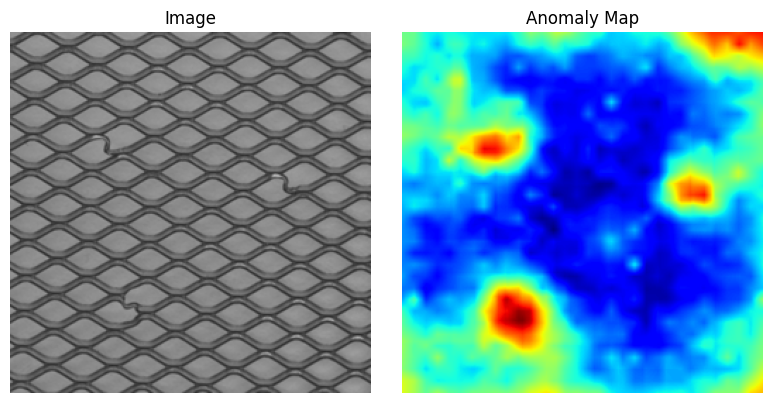

Selected class: hazelnut
✅ Loaded encoder from ./weights/encoder_hazelnut.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


✅ Test completed.
Detection AUROC: 98.43%


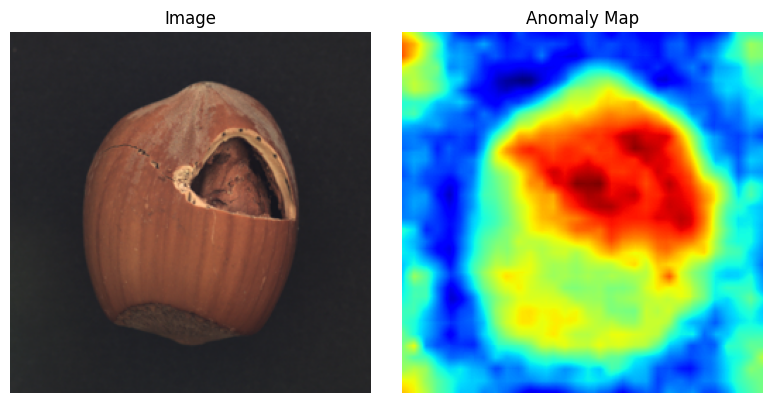

Selected class: leather
✅ Loaded encoder from ./weights/encoder_leather.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


✅ Test completed.
Detection AUROC: 100.00%


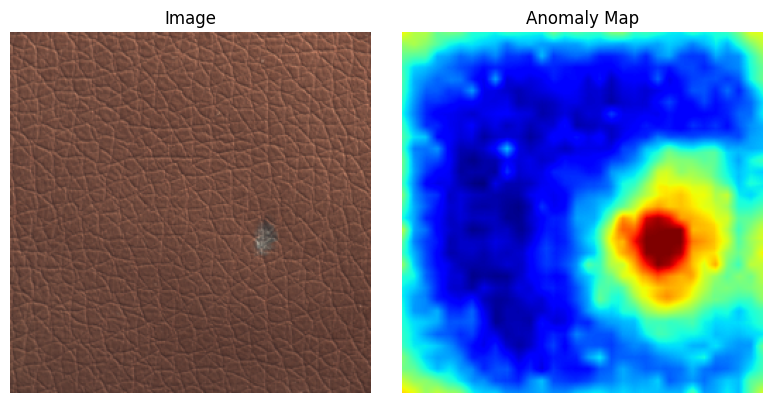

Selected class: metal_nut
✅ Loaded encoder from ./weights/encoder_metal_nut.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


✅ Test completed.
Detection AUROC: 98.34%


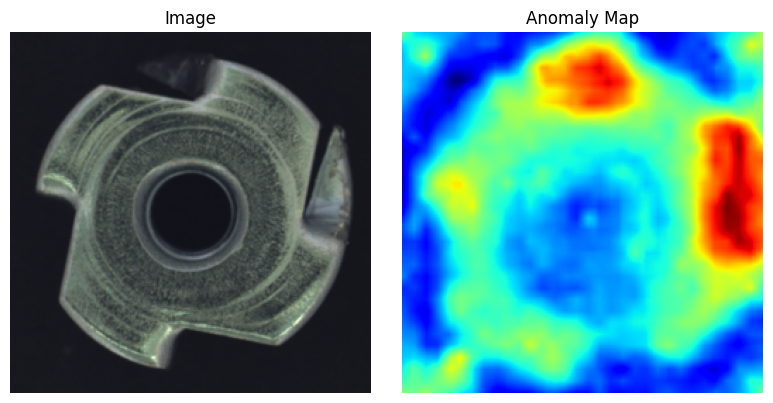

Selected class: pill
✅ Loaded encoder from ./weights/encoder_pill.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


✅ Test completed.
Detection AUROC: 93.13%


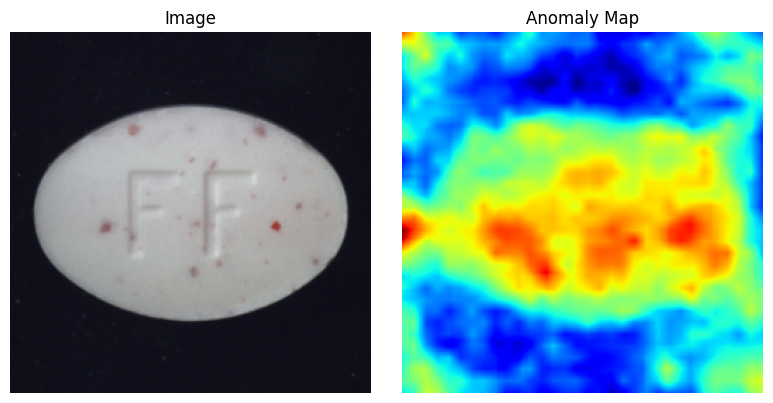

Selected class: screw
✅ Loaded encoder from ./weights/encoder_screw.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


✅ Test completed.
Detection AUROC: 76.70%


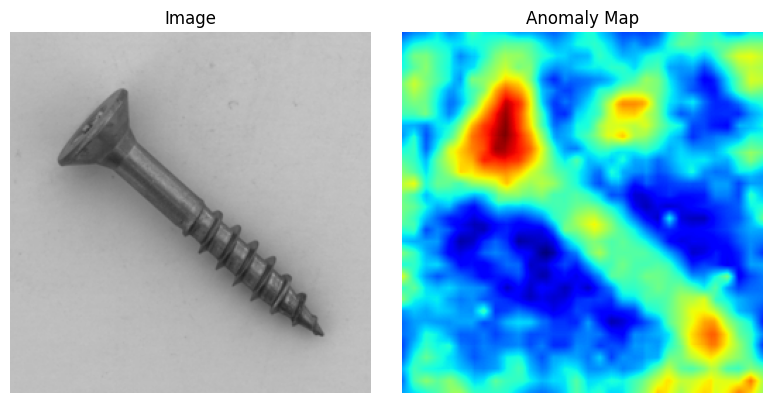

Selected class: tile
✅ Loaded encoder from ./weights/encoder_tile.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


✅ Test completed.
Detection AUROC: 98.88%


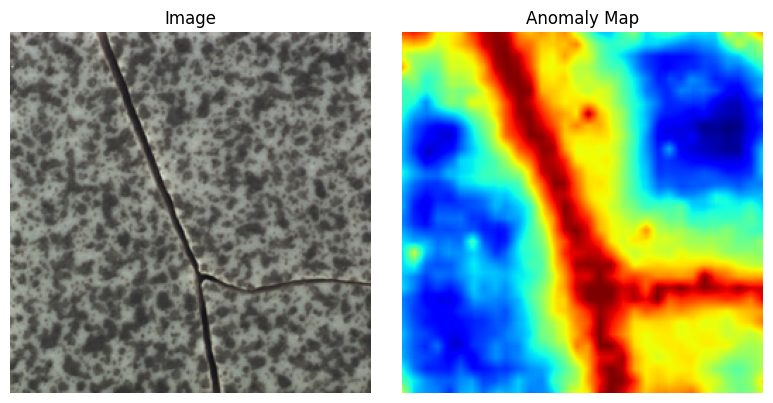

Selected class: toothbrush
✅ Loaded encoder from ./weights/encoder_toothbrush.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


✅ Test completed.
Detection AUROC: 90.83%


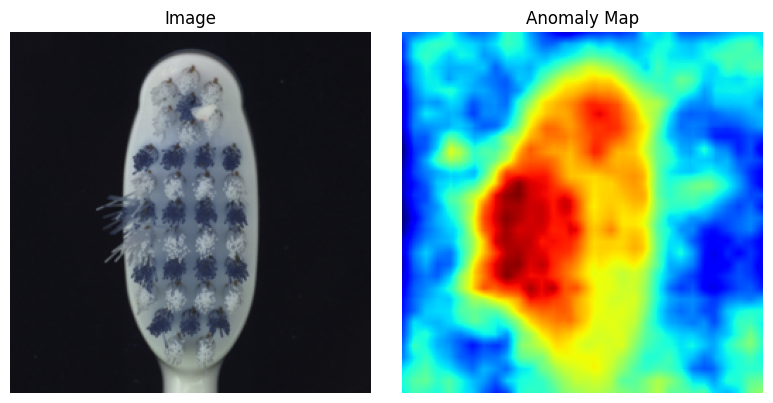

Selected class: transistor
✅ Loaded encoder from ./weights/encoder_transistor.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 13/13 [00:17<00:00,  1.36s/it]


✅ Test completed.
Detection AUROC: 95.17%


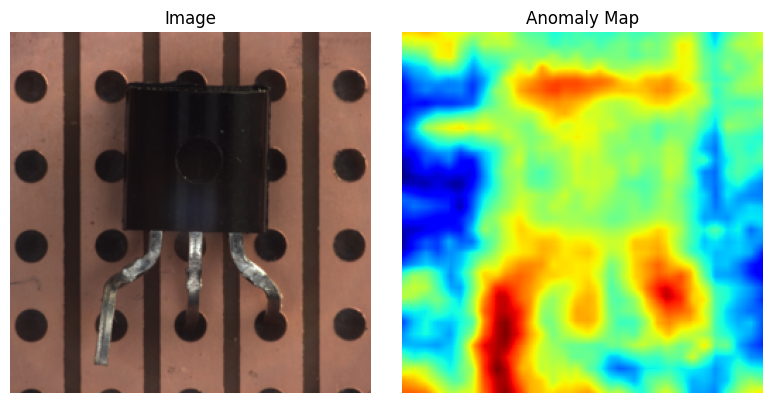

Selected class: wood
✅ Loaded encoder from ./weights/encoder_wood.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


✅ Test completed.
Detection AUROC: 98.42%


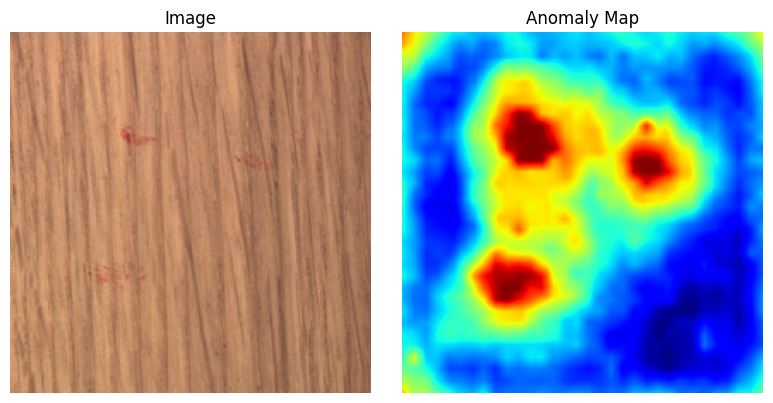

Selected class: zipper
✅ Loaded encoder from ./weights/encoder_zipper.pth
✅ Loaded 3 decoders from ./weights


Test: 100%|██████████| 19/19 [00:24<00:00,  1.27s/it]


✅ Test completed.
Detection AUROC: 94.04%


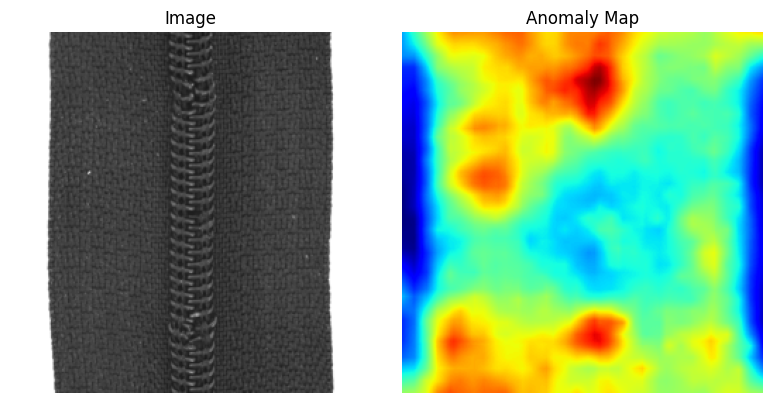

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mvtec_classes = {
    0: "grid",
    1: "hazelnut",
    2: "leather",
    3: "metal_nut",
    4: "pill",
    5: "screw",
    6: "tile",
    7: "toothbrush",
    8: "transistor",
    9: "wood",
    10: "zipper"
}
# Example: select class by number
for i in range(len(mvtec_classes)):
    CFG.class_name = mvtec_classes[i]   # "pill"
    print(f"Selected class: {CFG.class_name}")

    test_ds = MVTecDataset(CFG.dataset_path, CFG.class_name, False, CFG.input_size, CFG.input_size)
    test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.workers, pin_memory=True)
    # Assuming encoder, decoders, and dataset already defined
    heights, widths, dists, gt_label_list, gt_mask_list  = test_epoch_with_weights(encoder, decoders, test_loader, device, pool_layers, 
        acts, CFG.condition_dim, CFG.input_size,
        weight_dir="./weights" ,  # directory with encoder.pth & decoder_*.pth
        class_name=CFG.class_name
    )

    super_mask = compute_anomaly_map(dists, heights, widths, CFG.input_size, pool_layers)
    score_label = np.max(super_mask, axis=(1,2))
    gt_label = np.asarray(gt_label_list, dtype=bool)
    det_auroc = float(roc_auc_score(gt_label, score_label)*100)
    print(f"Detection AUROC: {det_auroc:.2f}%")
    idx = 0  # pick first image (or any index you like)
    img = Image.open(test_ds.x[idx]).convert('RGB').resize((CFG.input_size, CFG.input_size))

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 2 columns only

    # Original image
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[0].axis('off')

    # Anomaly map
    ax[1].imshow(super_mask[idx], cmap='jet')
    ax[1].set_title('Anomaly Map')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()